************Train Finished*************


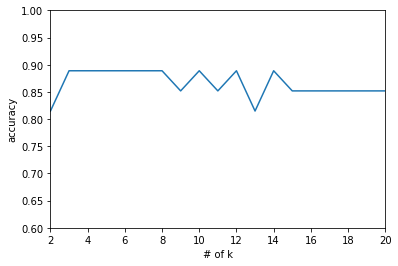

In [11]:
import numpy as np
import random,math
from matplotlib import pyplot as plt
from scipy.io import loadmat

##row sample  ---   n by d
##return 1 by n mat
def euclideanDistance(vec,mat=None)->float:
    if isinstance(mat,np.ndarray):
        return np.sum((vec-mat)**2,axis=1)**0.5
    else:
        return np.sum(vec**2)**0.5

def e_neg(x):
    return math.pow(math.e,-x)

def processNan(data:np.ndarray)->np.ndarray:
    def evenColumn(data:np.ndarray,col_num:int)->float:
        res=0
        num=0
        for row in data:
            if not np.isnan(row[col_num]):
                res+=row[col_num]
                num+=1
        return res/num

    for row in data:
        for i in range(len(row)):
            if np.isnan(row[i]):
                row[i]=evenColumn(data,i)
    return data/100

def findMinIndex(vector,num:int):

    def bubble_sort(indexes,vec):
        flag = True
        while flag:
            flag = False
            for i in range(len(indexes) - 1):
                if vec[indexes[i]] < vec[indexes[i + 1]]:
                    indexes[i], indexes[i + 1] = indexes[i + 1], indexes[i]
                    flag = True
        return indexes

    index_list=num*[-1]
    for i in range(len(vector)):
        for j in range(len(index_list)):
            if index_list[j]==-1:
                index_list[j]=i
                break
        bubble_sort(index_list,vector)
        if vector[i]<vector[index_list[0]]:
            index_list[0]=i
    return index_list

def knn(metric,train,test,category:int=3,k:int=5):  ## 引入metric符号，增强函数复用性，二个任务都用同一 knn 函数
    res=[]
    data,label=train
    random.seed()
    for i in range(test.shape[0]):
        dist_list=metric(test[i],data)
        nn=category*[0]
        sumd=category*[0]
        for j in findMinIndex(dist_list,k):
            nn[label[j]-1]+=1
            sumd[label[j]-1]+=dist_list[j]
        max=np.max(np.array(nn))
        quesera=[]
        for j in range(category):
            if nn[j]<max:
                continue
            else:
                quesera.append(j)
        ind=quesera[0]
        d=sumd[ind]
        for j in quesera:
            if sumd[j]<d:
                ind=j
                d=sumd[j]
        res.append(ind+1)
    return res

def check(res_hat:list,res_truth:list)->float:
    total=len(res_hat)
    count=0
    for i in range(total):
        if res_truth[i]==res_hat[i]:
            count+=1
    return count/total

class Mahalanobis:
    def __init__(self,train,category_num:int,e:int=2):
        self.data=train[0]
        self.label=train[1]
        self.cat=category_num
        self.e=e
        self.n,self.d=self.data.shape[0],self.data.shape[1]
        self.A = np.random.normal(0, 1, (self.e,self.d))

    def __call__(self):
        out=0
        for i in range(self.n):
            for j in range(self.n):  ## i=j p_ij=0 && p_ij = p_ji
                if self.label[j] == self.label[i]:
                    d = e_neg(self.mahalanobisDistance(self.data[i], self.data[j]) ** 2)
                    D = 0
                    for k in range(self.n):
                        if k != i:
                            D += e_neg(self.mahalanobisDistance(self.data[i], self.data[k]) ** 2)
                    out += d / D
                else:
                    continue
        print('loss: %.4f' % out)

    def __backward__(self):
        partial_A=np.zeros([self.e,self.d])
        for i in range(self.n):
            for j in range(self.n):  ## i=j p_ij=0 && p_ij = p_ji
                if self.label[j] == self.label[i] and i!=j:
                    lm_ij=self.mahalanobisDistance(self.data[i], self.data[j])
                    diff_ij=self.data[i]-self.data[j]
                    d = e_neg(lm_ij ** 2)
                    e = np.matmul(self.A, diff_ij[None].T)
                    e=e/euclideanDistance(e)
                    second=None
                    D = 0
                    for k in range(self.n):
                        if k != i:
                            lm_ik=self.mahalanobisDistance(self.data[i], self.data[k])
                            diff_ik=self.data[i] - self.data[k]
                            temp_d=e_neg(lm_ik ** 2)
                            temp_e = np.matmul(self.A, diff_ik[None].T)
                            temp_e = temp_e / euclideanDistance(temp_e)
                            D += e_neg(lm_ik ** 2)
                            temp=-2*lm_ik*temp_d*D*np.matmul(temp_e,diff_ik[None])
                            try:
                                second+=temp
                            except:
                                second=temp
                    second*=d
                    first=-2*lm_ij*d*np.matmul(e,diff_ij[None])*D
                    partial_A+=(first-second)/(D**2)
                else:
                    continue
        return partial_A

    def mahalanobisDistance(self,vec1,vec2):
        vec=np.matmul(vec1-vec2,self.A.T)**2
        try:
            vec=np.sum(vec,axis=1)
        except:
            vec=np.sum(vec)
        return vec**0.5

    def train(self,test,epoch:int=5,lr:float=1e-2,k_rangge=[2,20]):
        test_data,test_label=test
        k_s,k_e=k_rangge
        self.lr=lr
        acc=[[] for _ in range(epoch)]
        for i in range(epoch):
            partial=self.__backward__()
            ori_A=self.A.copy()
            self.A+=partial*self.lr
            diff=np.sum((ori_A-self.A)**2)
            if diff<1e-8:
                break
            else:
                for k in range(k_s,k_e+1):
                    pre=check(knn(self.mahalanobisDistance,[self.data,self.label],test_data,self.cat,k),test_label)
                    acc[i].append(pre)
                    #print('epoch: %d    accuracy: %.6f    K: %d' % (i+1,pre,k))
        print('************Train Finished*************')
        return acc

test_data = processNan(loadmat('./KNN分类任务/data/test_data.mat')['data'])
val_data,val_label = processNan(loadmat('./KNN分类任务/data/val_data.mat')['data']),np.squeeze(loadmat('./KNN分类任务/data/val_data.mat')['label'])
train_data,train_label = processNan(loadmat('./KNN分类任务/data/train_data.mat')['data']),np.squeeze(loadmat('./KNN分类任务/data/train_data.mat')['label'])
train=[train_data,train_label]
test=[val_data,val_label]
'''
#************task 1************#

start,end= 2,20
x=range(start,end+1)
y=[]
for i in range(start,end+1):
    y.append(check(knn(euclideanDistance,train,val_data,k=i),val_label))
plt.xlabel('# of k')
plt.ylabel('accuracy')
plt.title='Euclidean KNN'
plt.plot(x,y)
plt.xlim(start,end)
plt.ylim(0.6,1)
plt.show()
'''
#************task 2************#
k_s,k_e=2,20
epoch=5
m=Mahalanobis(train,category_num=3,e=5)
y_vec=m.train(test,epoch=epoch,k_rangge=[k_s,k_e])

x=range(k_s,k_e+1)

plt.xlabel('# of k')
plt.ylabel('accuracy')
plt.title='Mahalanobis KNN'
plt.plot(x,y_vec[-1])
plt.xlim(k_s,k_e)
plt.ylim(0.6,1)
plt.show()


res=knn(m.mahalanobisDistance,train,test_data,3,6)
    

standard=[]
import csv
with open('./KNN分类任务/sample_submission.csv','r',encoding='utf8')as f:
    f_csv = csv.reader(f)
    for row in f_csv:
        standard.append(row)

for i in range(len(res)):
    standard[i][0]=res[i]
    
        
with open('./task1_test_prediction.csv', 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    for list in standard:
        csv_writer.writerow(list)


